In [65]:
import pandas as pd
from sqlalchemy import create_engine

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from os import getenv
from dotenv import load_dotenv

load_dotenv(".env")
PASSWORD = getenv("PASSWORD")



In [66]:
# Database connection parameters

host_name='localhost'
username='root'
password=PASSWORD
database_name="dublinbikes"

# Create the SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host_name}/{database_name}')
#query = "SELECT last_update AS ds, available_bikes AS y FROM availability WHERE station_id=1"

query = """
SELECT S.station_id, S.bike_stands, A.last_update, A.available_bikes, A.available_bike_stands, W.temperature, W.humidity, W.weather_condition, W.wind_speed
FROM station S, availability A, weather_data W
WHERE S.station_id = A.station_id AND A.station_id = W.station_id AND W.last_update = A.last_update AND A.station_id = 22; 
"""


# Execute the query and load the data into a DataFrame
df = pd.read_sql(query, engine)


# Convert 'last_update' from UNIX time in milliseconds to datetime and set as index
df['last_update'] = pd.to_datetime(df['last_update'], unit='ms')
df.set_index('last_update', inplace=True)

# Add day_of_the_week (0 = Monday, 6 = Sunday)
df['day_of_the_week'] = df.index.dayofweek
df['hour'] = df.index.hour
df['is_weekend'] = df['day_of_the_week'].apply(lambda x: 1 if x >= 5 else 0)


# Convert temperature from Kelvin to Celsius
df['temperature'] = df['temperature'] - 273.15

# Aggregate numeric fields by mean and 'weather_condition' by mode
df_numeric = df.drop(columns=['weather_condition']).resample('30min').mean()
weather_condition_mode = df['weather_condition'].resample('30min').apply(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')

# Combine the aggregated data
df_hourly = df_numeric
df_hourly['weather_condition'] = weather_condition_mode

# Factorize the 'weather_condition' to turn it into a numeric variable
df_hourly['weather_condition_encoded'] = pd.factorize(df_hourly['weather_condition'])[0]
df_hourly.dropna(inplace=True)

df =df_hourly




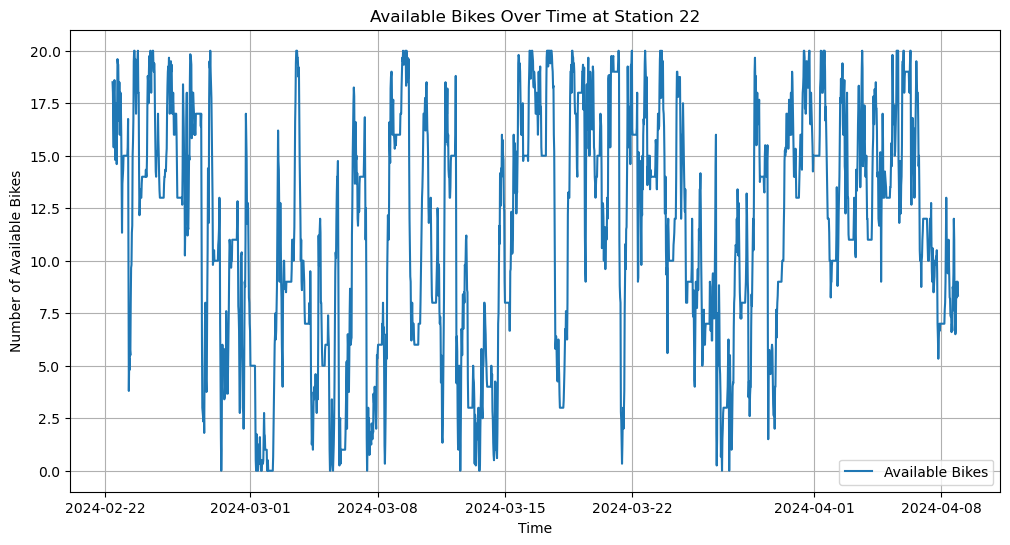

In [67]:
# Plotting the available bikes over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['available_bikes'], label='Available Bikes')
plt.title('Available Bikes Over Time at Station 22')
plt.xlabel('Time')
plt.ylabel('Number of Available Bikes')
plt.legend()
plt.grid(True)
plt.show()

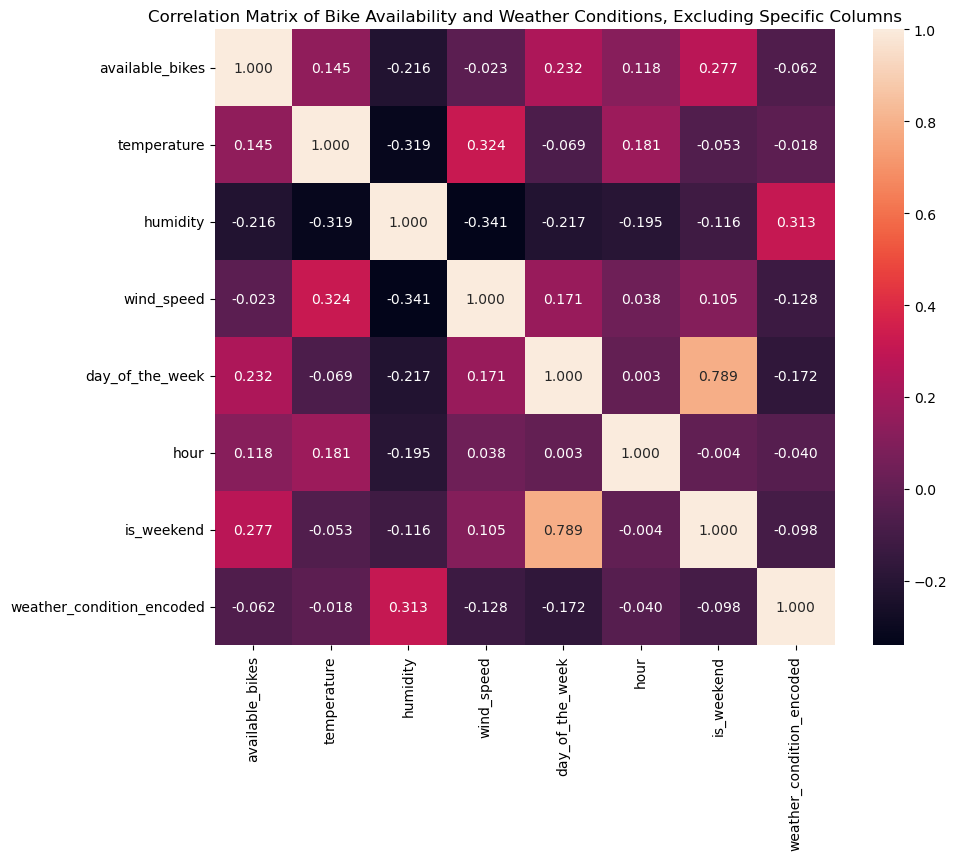

In [68]:
# Select the columns you want to include in the correlation matrix calculation
columns_for_corr = [col for col in df.columns if col not in ('station_id', 'available_bike_stands', 'bike_stands', 'date', 'last_update','weather_condition')]

numeric_df_for_corr = df[columns_for_corr].select_dtypes(include=[np.number])

# Calculate the correlation matrix for the selected columns
corr_matrix = numeric_df_for_corr.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".3f")
plt.title('Correlation Matrix of Bike Availability and Weather Conditions, Excluding Specific Columns')
plt.show()

In [69]:
X = df_hourly[['day_of_the_week', 'hour', 'weather_condition_encoded', 'is_weekend', 'temperature','humidity','wind_speed']]
y = df_hourly['available_bikes']

# Temporal train-test split
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)

# Initialize and fit the KNN Regressors and predict the target values
knn_regressor_bikes = KNeighborsRegressor(n_neighbors=5)
knn_regressor_bikes.fit(X_train_scaled, y_train)
y_pred = knn_regressor_bikes.predict(X_scaled)


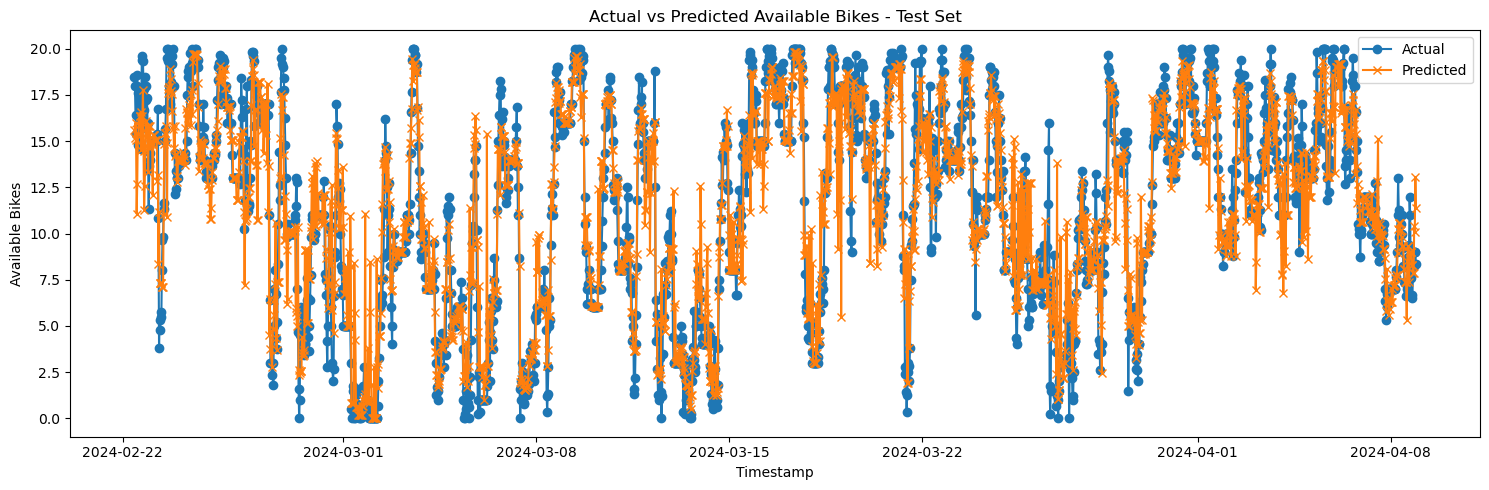

In [70]:

# Plot the test data and predictions
plt.figure(figsize=(15, 5))
plt.plot(y.index, y, label='Actual', marker='o')
plt.plot(y.index, y_pred, label='Predicted', marker='x')

plt.title('Actual vs Predicted Available Bikes - Test Set')
plt.xlabel('Timestamp')
plt.ylabel('Available Bikes')
plt.legend()
plt.tight_layout()
plt.show()


In [71]:
# Calculate MAE
mae = mean_absolute_error(y, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R-squared (R²)
r2 = r2_score(y, y_pred)
print(f"R-squared (R²): {r2}")


threshold = 2  # This means predictions within 2 bikes of the actual value are considered accurate

# Calculate the percentage of predictions within the threshold
accuracy_within_threshold = np.mean(np.abs(y - y_pred) <= threshold) * 100
print(f"Percentage of predictions within ±{threshold} bikes: {accuracy_within_threshold}%")

Mean Absolute Error (MAE): 1.4554221652786674
Mean Squared Error (MSE): 4.836992287402255
Root Mean Squared Error (RMSE): 2.199316322724463
R-squared (R²): 0.8438140141489802
Percentage of predictions within ±2 bikes: 74.61883408071749%
